Training set - 2023 Jan to 2024 March
Input window = 28

#### 1. Import the libraries

In [1]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: '/anaconda/envs/azureml_py38/lib/python3.10/site-packages/numpy-1.23.5.dist-info/METADATA'



2024-11-06 21:32:36.790317: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 21:32:38.865898: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730928759.533432    3109 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730928759.735772    3109 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 21:32:41.742950: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
pip install scipy scikit-learn

Note: you may need to restart the kernel to use updated packages.


#### 2. Pre processing the dataset

In [5]:
# load dataset
data = pd.read_csv('LL_data.csv')

In [6]:
data.tail()

,Received_Timestamp,Latitude,Longitude
796631,2024-08-16 20:26:55,6.301900,94.509340
796632,2024-08-16 20:41:52,6.304237,94.558950
796633,2024-08-16 20:44:07,6.304650,94.566895
796634,2024-08-16 20:44:45,6.304758,94.569090
796635,2024-08-16 21:01:24,6.306820,94.625694


In [7]:
data['Received_Timestamp'] = pd.to_datetime(data['Received_Timestamp'])  # Convert to datetime
data['Latitude'] = pd.to_numeric(data['Latitude'], errors='coerce')       # Convert to numeric, handling errors
data['Longitude'] = pd.to_numeric(data['Longitude'], errors='coerce')     # Convert to numeric, handling errors
data = data.dropna()  # Drop rows with NaN values if any remain

In [8]:
data.set_index('Received_Timestamp', inplace=True)  # Set datetime as the index

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 796636 entries, 2023-01-01 00:36:49 to 2024-08-16 21:01:24
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Latitude   796636 non-null  float64
 1   Longitude  796636 non-null  float64
dtypes: float64(2)
memory usage: 18.2 MB


In [10]:
# Resample data to six-hour bins, handling empty bins with interpolation
data = data.resample('6H').mean()  # Bin by six hours with mean aggregation
data = data.interpolate(method='linear')  # Linear interpolation for missing bins

/tmp/ipykernel_3109/4293368568.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data = data.resample('6H').mean()  # Bin by six hours with mean aggregation


In [11]:
data.head()

,Latitude,Longitude
Received_Timestamp,,
2023-01-01 00:00:00,23.954669,61.666054
2023-01-01 06:00:00,23.719084,62.527122
2023-01-01 12:00:00,23.347651,63.845577
2023-01-01 18:00:00,23.076742,64.817208
2023-01-02 00:00:00,22.740178,66.021411


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2376 entries, 2023-01-01 00:00:00 to 2024-08-16 18:00:00
Freq: 6h
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   2376 non-null   float64
 1   Longitude  2376 non-null   float64
dtypes: float64(2)
memory usage: 55.7 KB


In [13]:
# Normalize the Latitude and Longitude values
# Initialize a MinMaxScaler to scale latitude and longitude data to the range [0, 1]
scaler = MinMaxScaler()
# Apply the scaler to the 'Latitude' and 'Longitude' columns
data[['Latitude', 'Longitude']] = scaler.fit_transform(data[['Latitude', 'Longitude']])

In [14]:
# Training set: Entire year of 2023 and up to August 2024
training_set = data.loc['2023':'2024-02']

# Testing set: Remaining months in 2024, starting from September 2024
testing_set = data.loc['2024-03':]


In [15]:
training_set.head()

,Latitude,Longitude
Received_Timestamp,,
2023-01-01 00:00:00,0.545963,0.603455
2023-01-01 06:00:00,0.543781,0.609879
2023-01-01 12:00:00,0.540342,0.619715
2023-01-01 18:00:00,0.537833,0.626964
2023-01-02 00:00:00,0.534716,0.635948


In [16]:
testing_set.head()

,Latitude,Longitude
Received_Timestamp,,
2024-03-01 00:00:00,0.541115,0.001624
2024-03-01 06:00:00,0.548333,0.001873
2024-03-01 12:00:00,0.559416,0.002246
2024-03-01 18:00:00,0.570363,0.002649
2024-03-02 00:00:00,0.581073,0.003018


#### 3. Sliding window approach

In [17]:
# Define the input window size (20 data points)
input_window_size = 28
# Define the output window size (1 data point)
output_window_size = 1
# Define the stride, which determines how much to move forward for each new window (1 data point)
stride = 1

In [18]:
# Apply sliding window to create sequences
# Initialize empty lists to store the input (X) and output (y) sequences
X, y = [], []

# Loop through the dataset to create windows of input and output sequences
for i in range(0, len(training_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window, which is a slice of 20 data points
    input_window = training_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window, which is a slice of 1 data point immediately following the input window
    output_window = training_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window data to X and the last value of output window to y
    X.append(input_window.values)
    y.append(output_window.values[-1])

In [19]:
# Convert X and y lists to numpy arrays for model input
X, y = np.array(X), np.array(y)

# Print the number of samples created
print(f"Number of samples: {X.shape[0]}")
# Print the shape of the input (X) and output (y) arrays
print(f"Input shape: {X.shape}, Target shape: {y.shape}")

Number of samples: 1672
Input shape: (1672, 28, 1), Target shape: (1672, 1)


#### 4. Define LSTM model architecture

In [20]:
# Define the LSTM model creation function with parameter options
# Import the Adam optimizer
from tensorflow.keras.optimizers import Adam

# Define a function to create an LSTM model with specified hyperparameters
def build_model(units=50, lstm_layers=2, dropout_rate=0.2, recurrent_dropout=0.2, activation='relu', learning_rate=0.001):
    # Initialize a Sequential model
    model = Sequential()

    # Add LSTM layers based on the specified number of layers
    for i in range(lstm_layers - 1):
        # For stacked LSTM layers, set return_sequences=True to allow output sequences
        model.add(LSTM(units=units, activation=activation, return_sequences=True, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))
    
    # Add a final LSTM layer without return_sequences for a many-to-one model
    model.add(LSTM(units=units, activation=activation, dropout=dropout_rate, recurrent_dropout=recurrent_dropout))

    # Add a Dense layer with 1 unit (for Latitude ) as the output layer
    model.add(Dense(1))

    # Initialize the Adam optimizer with the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    
    # Compile the model using mean squared error (MSE) as the loss function for regression
    model.compile(optimizer=optimizer, loss='mse')
    
    # Return the constructed model
    return model

In [21]:
# Initialize variables to store the best model and lowest validation loss
best_model = None
best_loss = float('inf')  # Set the initial best loss to infinity for comparison

# Define hyperparameter grid for units, layers, dropout, learning rates, and batch sizes
units_list = [30, 50, 100]
layers_list = [1, 2,3]
dropout_list = [0.2, 0.3,0.5]
learning_rates = [0.001, 0.01,0.0001]
batch_sizes = [16, 32,48]

In [22]:
# Perform a grid search over all combinations of hyperparameters
for units in units_list:
    for layers in layers_list:
        for dropout in dropout_list:
            for lr in learning_rates:
                for batch_size in batch_sizes:
                    # Print the current combination of hyperparameters being tested
                    print(f"Training model with units={units}, layers={layers}, dropout={dropout}, lr={lr}, batch_size={batch_size}")

                    # Build a model with the current hyperparameter settings
                    model = build_model(units=units, lstm_layers=layers, dropout_rate=dropout, learning_rate=lr)

                    # Early stopping and training the model
                    # Initialize early stopping to monitor validation loss with patience of 5 epochs
                    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
                    
                    # Train the model on the data with an 80-20 validation split
                    history = model.fit(X, y, epochs=50, batch_size=batch_size, validation_split=0.3, callbacks=[early_stopping], verbose=1)

                    # Get the minimum validation loss in the training history
                    val_loss = min(history.history['val_loss'])

                    # Check if the current model has a lower validation loss than the best so far
                    if val_loss < best_loss:
                        # Update the best model and parameters
                        best_loss = val_loss
                        best_model = model
                        best_params = (units, layers, dropout, lr, batch_size)
                        best_history = history


Training model with units=30, layers=1, dropout=0.2, lr=0.001, batch_size=16
Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2281 - val_loss: 0.0151
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0076 - val_loss: 0.0205
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 0.0224
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0022 - val_loss: 0.0235
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0012 - val_loss: 0.0257
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0011 - val_loss: 0.0262
Training model with units=30, layers=1, dropout=0.2, lr=0.001, batch_size=32
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2887 - val_loss: 0.0245
Epoch 2/50


2024-11-06 21:32:55.964622: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


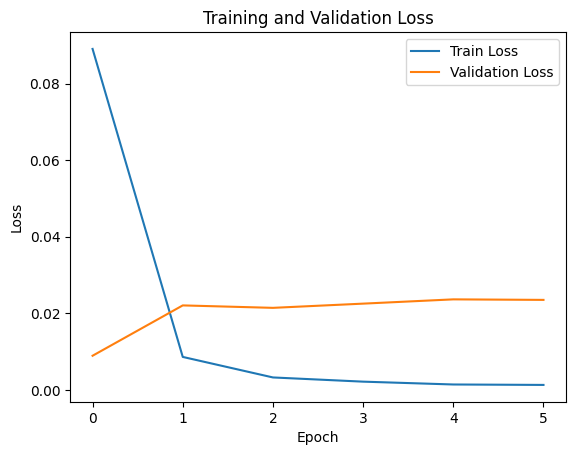

In [23]:
# Plot the training history of the best model
# Plot the loss and validation loss over epochs for the best model
plt.plot(best_history.history['loss'], label='Train Loss')
plt.plot(best_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [24]:
# Output the best model parameters
# Print the best hyperparameters found in the grid search
print(f"Best model parameters: Units={best_params[0]}, Layers={best_params[1]}, Dropout={best_params[2]}, Learning Rate={best_params[3]}, Batch Size={best_params[4]}")

Best model parameters: Units=50, Layers=1, Dropout=0.2, Learning Rate=0.001, Batch Size=48


In [25]:
#best_model.save('LL Prediction 1.h5')

### Testing Part

#### 1) Load the model

In [26]:
best_model

<Sequential name=sequential_83, built=True>

#### 2) Window sampling for testing set

In [27]:
import numpy as np

# Parameters for window sampling
input_window_size = 28
output_window_size = 1
stride = 1

# Initialize lists to store the input (X_test) and output (y_test) sequences for testing set
X_test, y_test = [], []

# Loop through the testing set to create windows of input and output sequences
for i in range(0, len(testing_set) - input_window_size - output_window_size + 1, stride):
    # Define the input window (20 data points)
    input_window = testing_set.iloc[i:i+input_window_size][['Latitude']]
    # Define the output window (1 data point immediately following the input window)
    output_window = testing_set.iloc[i+input_window_size:i+input_window_size+output_window_size][['Latitude']]
    # Append the input window to X_test and the last value of output window to y_test
    X_test.append(input_window.values)
    y_test.append(output_window.values[-1])

# Convert X_test and y_test lists to numpy arrays for model input
X_test, y_test = np.array(X_test), np.array(y_test)

# Print the number of samples created for testing
print(f"Number of test samples: {X_test.shape[0]}")
print(f"Test input shape: {X_test.shape}, Test target shape: {y_test.shape}")

Number of test samples: 648
Test input shape: (648, 28, 1), Test target shape: (648, 1)


#### 3) Test the Testing Set Using the Imported Model

In [28]:
best_model

<Sequential name=sequential_83, built=True>

In [29]:
# Make predictions on the testing set
y_pred = best_model.predict(X_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


#### 4) Calculate Error on the Testing Set

In [30]:
y_test

array([[0.72558625],
       [0.72657459],
       [0.72963532],
       [0.73151199],
       [0.73033511],
       [0.72818631],
       [0.72670491],
       [0.72576318],
       [0.72576338],
       [0.72576337],
       [0.72576342],
       [0.72576358],
       [0.72576253],
       [0.72631554],
       [0.72887283],
       [0.74114104],
       [0.7488761 ],
       [0.75656808],
       [0.76921204],
       [0.77696776],
       [0.78102901],
       [0.78571715],
       [0.78852959],
       [0.79065314],
       [0.79730607],
       [0.80505564],
       [0.81195722],
       [0.82089809],
       [0.82886427],
       [0.83810245],
       [0.84274481],
       [0.85046184],
       [0.85937814],
       [0.86253028],
       [0.86689806],
       [0.8751615 ],
       [0.88561521],
       [0.89602931],
       [0.90758665],
       [0.91451102],
       [0.92664169],
       [0.93359652],
       [0.94114814],
       [0.9507044 ],
       [0.95704071],
       [0.96354469],
       [0.96932753],
       [0.975

In [31]:
y_pred

array([[0.57625633],
       [0.5782939 ],
       [0.58011967],
       [0.5819543 ],
       [0.5836811 ],
       [0.5850362 ],
       [0.58599466],
       [0.58667105],
       [0.5871499 ],
       [0.5875463 ],
       [0.58787084],
       [0.5881353 ],
       [0.5883485 ],
       [0.5885202 ],
       [0.58870846],
       [0.5891004 ],
       [0.59058726],
       [0.5925637 ],
       [0.5949925 ],
       [0.5982921 ],
       [0.60186535],
       [0.6053482 ],
       [0.6088187 ],
       [0.6120919 ],
       [0.61513394],
       [0.61841065],
       [0.62197477],
       [0.62570685],
       [0.6297924 ],
       [0.6340861 ],
       [0.63869375],
       [0.6431204 ],
       [0.6477131 ],
       [0.652554  ],
       [0.6570428 ],
       [0.66137075],
       [0.6659315 ],
       [0.6708972 ],
       [0.67620724],
       [0.6819438 ],
       [0.68759143],
       [0.6937035 ],
       [0.6996787 ],
       [0.7056211 ],
       [0.7117174 ],
       [0.7176208 ],
       [0.72339374],
       [0.728

In [32]:
from sklearn.metrics import mean_squared_error

# Calculate MSE between predicted and actual values
error = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error on the Testing Set: {error}")

Mean Squared Error on the Testing Set: 0.015536752804624552


In [33]:
# Get the original data for predicted cells and add it to testing set as a new column
# Convert predictions to a DataFrame for easier concatenation
predictions_df = pd.DataFrame(y_pred, columns=['Predicted_Latitude'])

In [34]:
predictions_df.head()

,Predicted_Latitude
0,0.576256
1,0.578294
2,0.580120
3,0.581954
4,0.583681


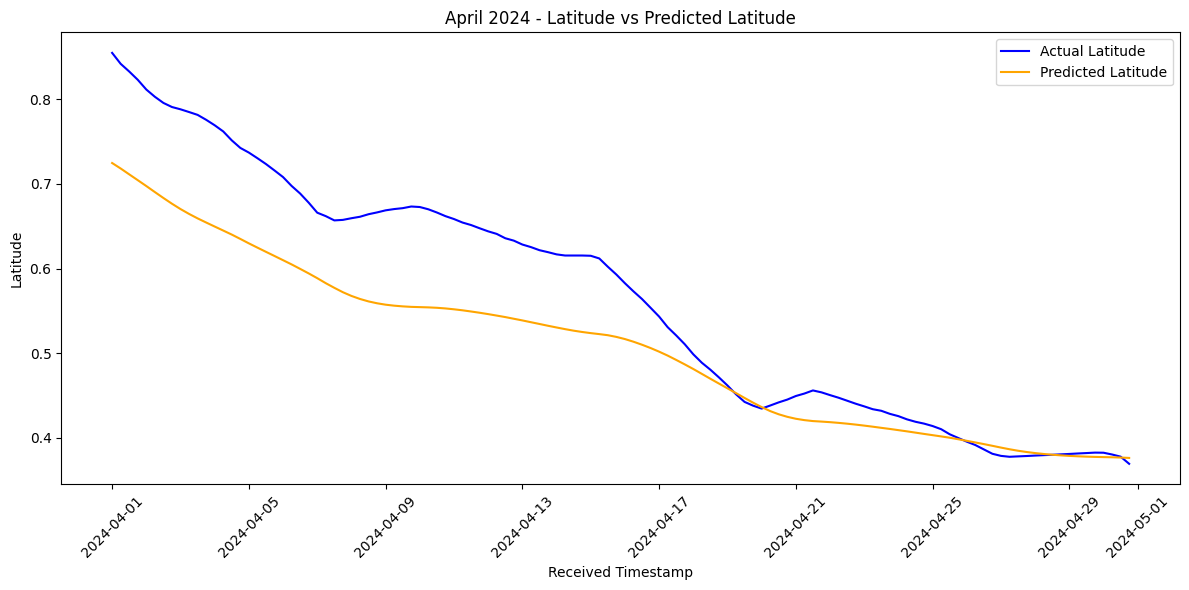

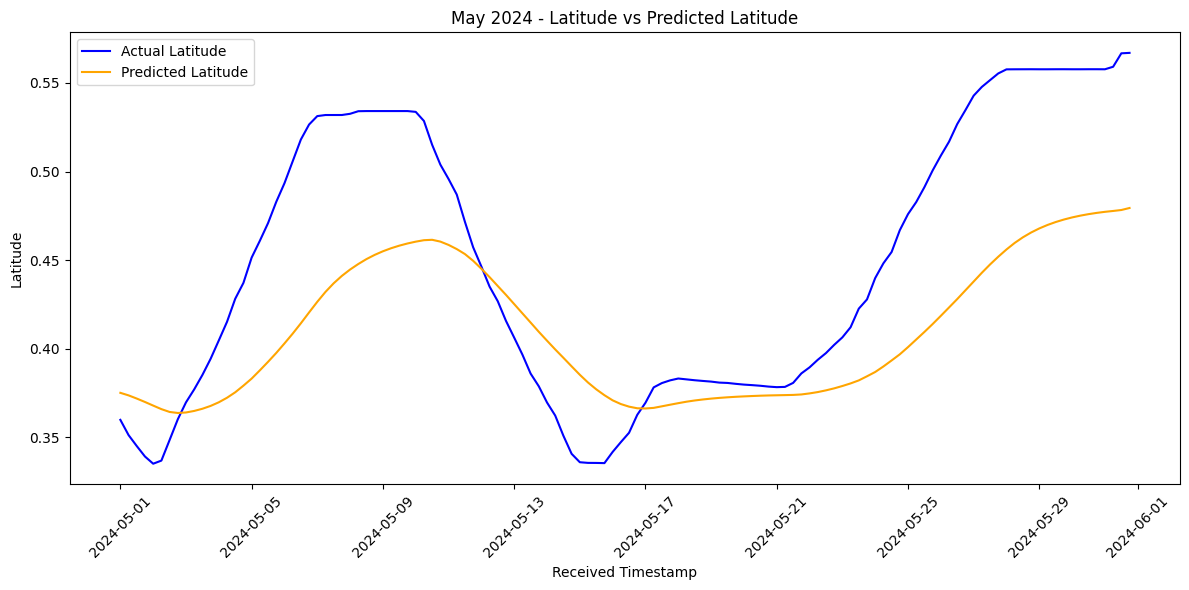

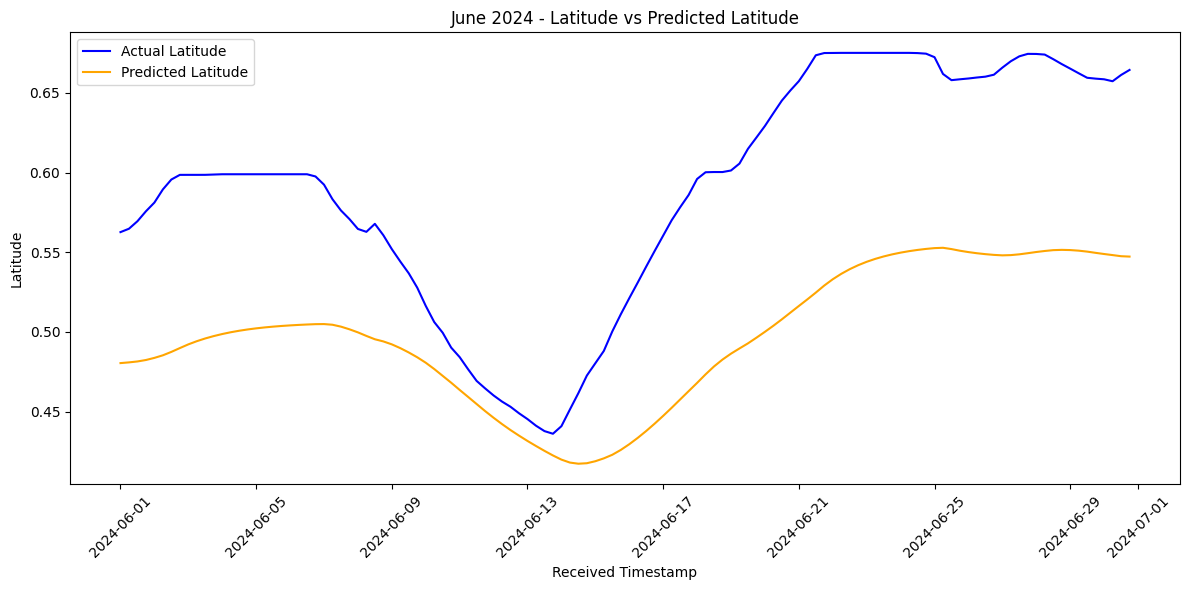

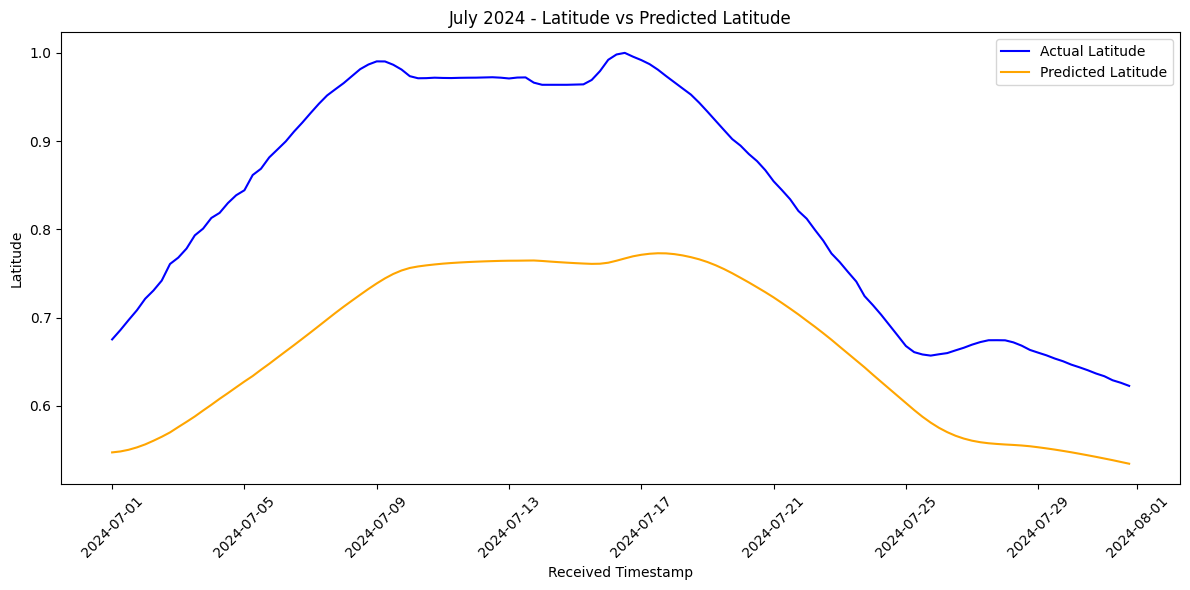

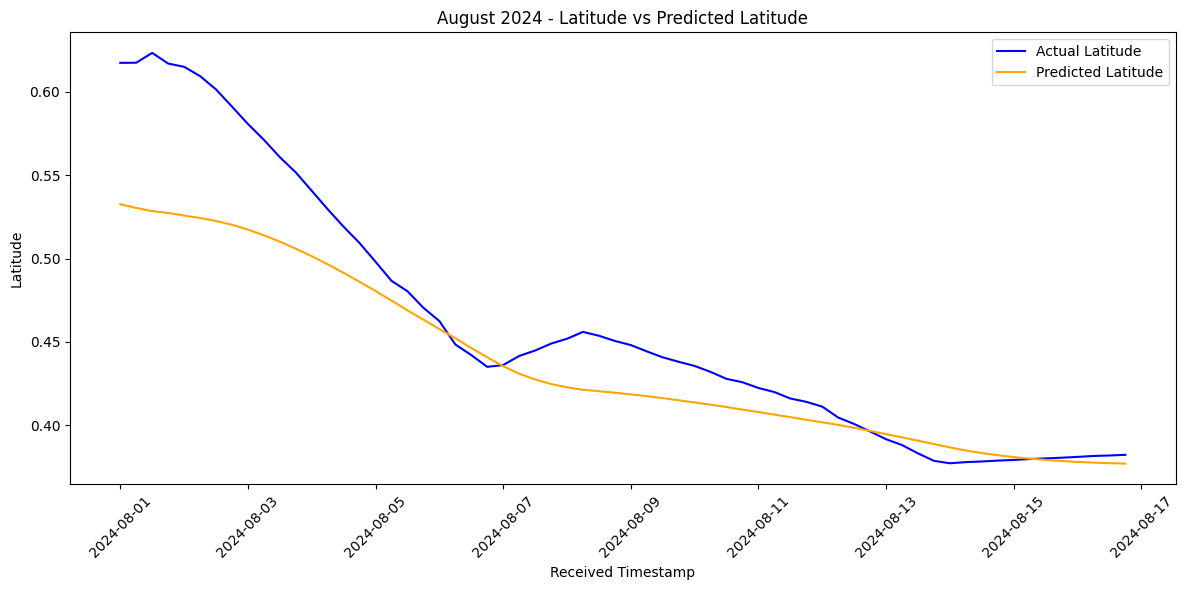

In [51]:
# Convert the predictions (y_pred) into a DataFrame for easy handling with timestamps
# We assume `testing_set.index[input_window_size:]` matches the `y_pred` in length
predicted_latitudes = pd.DataFrame(y_pred, index=testing_set.index[input_window_size:], columns=['Predicted_Latitude'])

# Add the 'Latitude' column from `testing_set` as the true values for comparison
testing_latitudes = testing_set[['Latitude']].iloc[input_window_size:]  # Skip initial window

# Define the months for filtering and specific timestamps for illustration
months = {
    'April': '2024-04',
    'May': '2024-05',
    'June': '2024-06',
    'July': '2024-07',
    'August': '2024-08'
}

# Plot each month's data
for month_name, month_str in months.items():
    # Filter data for the entire month
    monthly_actual_data = testing_latitudes[testing_latitudes.index.to_period('M') == month_str]
    monthly_predicted_data = predicted_latitudes[predicted_latitudes.index.to_period('M') == month_str]
    
    # Plot actual vs predicted latitude values for the month
    plt.figure(figsize=(12, 6))
    plt.plot(monthly_actual_data.index, monthly_actual_data['Latitude'], label='Actual Latitude', color='blue')
    plt.plot(monthly_predicted_data.index, monthly_predicted_data['Predicted_Latitude'], label='Predicted Latitude', color='orange')
    
    # Formatting the plot
    plt.title(f'{month_name} 2024 - Latitude vs Predicted Latitude')
    plt.xlabel('Received Timestamp')
    plt.ylabel('Latitude')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
